In [1]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!pip install dill rectools lightfm shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.9 MB/s eta 0:00:00
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808331 sha256=1d3f1d2739948a403c21b026ea0e98db8ff930b8fe19820db2270edf48345eab
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


# Импорты

In [3]:
import warnings

warnings.simplefilter("ignore")

from typing import Any, Dict, Tuple
from zipfile import ZipFile

import dill
import numpy as np
import pandas as pd
import requests
import shap
from lightfm import LightFM
from lightfm.data import Dataset
from lightgbm import LGBMClassifier, LGBMRanker
from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.metrics import MAP, NDCG, MeanInvUserFreq, Precision, Recall, calc_metrics
from rectools.models.popular import PopularModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tools import avg_user_metric, generate_lightfm_recs_mapper
from tqdm.auto import tqdm

In [4]:
interactions = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/kion_dataset/interactions.csv"
)
items = pd.read_csv("/content/drive/MyDrive/itmo_recsys/kion_dataset/items.csv")
users = pd.read_csv("/content/drive/MyDrive/itmo_recsys/kion_dataset/users.csv")

In [5]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        "last_watch_dt": Columns.Datetime,
        "watched_pct": Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions["datetime"] = interactions["datetime"].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.0,
    "total_dur": 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [6]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype("category").cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype("category")
    return df, cat_col_encoding


users_cat_cols = [
    # 'user_id',
    "age",
    "income",
    "sex",
    "kids_flg",
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding["income"], users["income"].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [7]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [8]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    "content_type",
    "for_kids",
    "studios",
]
items_text_cols = [
    "title",
    "title_orig",
    "genres",
    "countries",
    "directors",
    "actors",
    "description",
    "keywords",
]
items_num_cols = [
    "release_year",
    "age_rating",
]
default_values_items = {
    "release_year": items["release_year"].median(),
    "age_rating": items["age_rating"].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding["studios"]

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

# Трейн-вал-тест

In [9]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")
print(f"Продолжительность: {max_date - min_date}")

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [10]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(
    ranker_data["user_id"].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users,
    random_state=42,
    test_size=val_size / (train_size + val_size),  # 15% от общего размера
)

In [11]:
# Для базовых моделей первого уровня (в нашем случае только lightfm)
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

# Обучаем модель первого уровня

In [12]:
# В рамках семинара мы не будем обучать большое количество моделей первого уровня и
# ограничимся только LightFM
lightfm_dataset = Dataset()
lightfm_user_ids = base_models_data["user_id"].unique()
lightfm_item_ids = base_models_data["item_id"].unique()
lightfm_dataset.fit(lightfm_user_ids, lightfm_item_ids)

In [13]:
# В качестве таргета можно придумать что-то сложное на основе имеющихся
# процента досмотра или абсолютного значения просмотра.
# Как один из вариантов - возьмем процент досмотра - watched_pct (Columns.Weight).

# Тогда матрицу интеракций и весов можно получить следующим образом:
interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
    zip(*base_models_data[["user_id", "item_id", Columns.Weight]].values.T)
)
weights_matrix = weights_matrix.tocsr()

In [16]:
%%time

# Обучаем модель
# Не используем доступные фичи юзеров и айтемов, оставим это на этап реранжирования

lfm_model = LightFM(
    no_components=64,
    learning_rate=0.01,
    loss="warp",
    max_sampled=5,
    random_state=42,
)

num_epochs = 5

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 57.9 s, sys: 321 ms, total: 58.2 s
Wall time: 59.6 s


# Генерим кандидатов

In [14]:
# Маппинги обычных айдишников во внутренние индексы lightfm для юзеров и айтемов
lightfm_mapping = lightfm_dataset.mapping()
lightfm_mapping = {
    "user_id_to_iid": lightfm_mapping[0],  # iid - internal lfm id
    "item_id_to_iid": lightfm_mapping[2],
}
# Маппинги внутренние индексов lightfm в обычные айдишники для юзеров и айтемов
lightfm_mapping["user_iid_to_id"] = {
    v: k for k, v in lightfm_mapping["user_id_to_iid"].items()
}
lightfm_mapping["item_iid_to_id"] = {
    v: k for k, v in lightfm_mapping["item_id_to_iid"].items()
}

In [17]:
# Топ 100 кандидатов
# Как понять сколько их нужно?
top_N = 60

# Внутренние индексы юзеров и айтемов lightfm (индексы матрицы user-item)
user_lfm_index = np.array(list(lightfm_mapping["user_id_to_iid"].values()))
item_lfm_index = np.array(list(lightfm_mapping["item_id_to_iid"].values()))

# Делаем предикт, ограничиваем его сверху top_N
# и сразу переводим в настоящие айдишники
mapper = generate_lightfm_recs_mapper(
    model=lfm_model,
    N=top_N,
    item_iids=item_lfm_index,
    user_id_to_iid=lightfm_mapping["user_id_to_iid"],
    item_iid_to_id=lightfm_mapping["item_iid_to_id"],
    known_item_ids=dict(),  # тут можно добавить уже просмотренный контент для его исключения
    num_threads=2,
)

In [17]:
# Генерируем предсказания и получаем скоры и ранги lightfm

candidates = pd.DataFrame({"user_id": lightfm_user_ids})
candidates["item_id"], candidates["lfm_score"] = zip(*candidates["user_id"].map(mapper))
candidates = candidates.explode(["item_id", "lfm_score"], ignore_index=True)
candidates["lfm_rank"] = candidates.groupby("user_id").cumcount() + 1

# Делаем чекпоинт - сохраняем кандидатов
candidates.to_csv("lfm_candidates.csv", index=False)

candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank
0,176549,9728,4.443972,1
1,176549,13865,4.404545,2
2,176549,10440,4.186193,3


In [18]:
!cp lfm_candidates.csv /content/drive/MyDrive/itmo_recsys/lesson_6/

In [19]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        "ndcg@10": NDCG(k=10),
        "map@10": MAP(k=10),
        "Precision@10": Precision(k=10),
        "recall@10": Recall(k=10),
        "novelty@10": MeanInvUserFreq(k=10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df.rename(columns={rank_col: Columns.Rank})[
                [Columns.User, Columns.Item, Columns.Rank]
            ][candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                ranker_data[Columns.User].isin(test_users)
            ]
        ),
        prev_interactions=(
            base_models_data[
                [Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]
            ][base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items["item_id"].unique(),
    )


models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics["lfm"] = calc_metrics_(candidates, "lfm_rank")
models_metrics["lfm"]

{'Precision@10': 0.0240741024971989,
 'recall@10': 0.0801540690297259,
 'ndcg@10': 0.02847301406069679,
 'map@10': 0.036103614425445525,
 'novelty@10': 2.9783869375656447}

In [6]:
lfm_candidates = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/lesson_6/lfm_candidates.csv"
)

# Популярное для работы с холодными юзерами (из лекции 3)

In [7]:
lfm_candidates.head()

,user_id,item_id,lfm_score,lfm_rank
0,176549,9728,4.443972,1
1,176549,13865,4.404545,2
2,176549,10440,4.186193,3
3,176549,3734,4.130171,4
4,176549,15297,4.037317,5


In [12]:
interactions = Interactions(interactions)
cold_users = list(
    set(interactions.df.user_id.unique()) - set(lfm_candidates.user_id.unique())
)

popular_model = PopularModel()
dataset = Dataset.construct(
    interactions_df=interactions.df,
    user_features_df=None,
    item_features_df=None,
)
catalog = interactions.df[Columns.Item].unique()
popular_model.fit(dataset)

# рекомендуем только для холодных
recos = popular_model.recommend(
    users=cold_users, dataset=dataset, k=60, filter_viewed=True
)

In [13]:
recos.to_csv("popular_candidates.csv", index=False)

In [14]:
!cp popular_candidates.csv /content/drive/MyDrive/itmo_recsys/lesson_6/

# Датасет для ранкера

## Генерим фичи

In [12]:
# Получаем длину истории юзера
base_models_data["user_hist"] = base_models_data.groupby("user_id")[
    "item_id"
].transform("count")
# Получаем популярность контента
base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform(
    "count"
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")[
    "item_pop"
].transform("mean")
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")[
    "user_hist"
].transform("mean")
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")[
    "item_pop"
].transform("first")
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [13]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(
        base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()
    ),
    how="left",
    on="item_id",
)

users = pd.merge(
    left=users,
    right=(
        base_models_data[
            ["user_id", "user_hist", "user_avg_pop", "user_last_pop"]
        ].drop_duplicates()
    ),
    how="left",
    on="user_id",
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [14]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
}

In [5]:
lfm_candidates = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/lesson_6/lfm_candidates.csv"
)
popular_candidates = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/lesson_6/popular_candidates.csv"
)

In [16]:
lfm_candidates.head()

,user_id,item_id,lfm_score,lfm_rank
0,176549,9728,4.443972,1
1,176549,13865,4.404545,2
2,176549,10440,4.186193,3
3,176549,3734,4.130171,4
4,176549,15297,4.037317,5


In [17]:
popular_candidates.head()

,user_id,item_id,score,rank
0,1,15297,193123.0,1
1,1,9728,132865.0,2
2,1,13865,122119.0,3
3,1,4151,91167.0,4
4,1,3734,74803.0,5


In [6]:
candidates = pd.concat(
    [
        lfm_candidates.drop("lfm_score", axis=1).rename(columns={"lfm_rank": "rank"}),
        popular_candidates.drop("score", axis=1).rename(columns={"rank": "rank"}),
    ]
)

In [7]:
candidates.head()

,user_id,item_id,rank
0,176549,9728,1
1,176549,13865,2
2,176549,10440,3
3,176549,3734,4
4,176549,15297,5


In [8]:
candidates.to_csv("final_candidates.csv", index=False)

In [9]:
!cp final_candidates.csv /content/drive/MyDrive/itmo_recsys/lesson_6/

In [15]:
candidates = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/lesson_6/final_candidates.csv"
)

## Джойним кандидатов и юзер-айтем фичи

In [16]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты


def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="right",  # right ?
        on=["user_id", "item_id"],
    )
    # Проставляем дефолтные значения интеракций
    max_rank: int = df["rank"].max() + 1  # 101

    default_values = {
        "rank": max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,rank
7039835,3,101,2021-07-01,0.0,0.0,36
7039809,3,142,2021-08-13,5892.0,100.0,10
7039858,3,657,2021-07-01,0.0,0.0,59


In [17]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,rank,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,101,2021-07-01,0.0,0.0,36,-1,-1,-1,-1,0.0,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673
1,3,142,2021-08-13,5892.0,100.0,10,-1,-1,-1,-1,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
2,3,657,2021-07-01,0.0,0.0,59,-1,-1,-1,-1,0.0,11957.864865,2858.0,0,2015.0,-1,18.0,-1,7157.0,23.835266


In [18]:
# Датасеты готовы, остались только таргеты,
# которые можно посчитать на основе колонок total_dur и watched_pct

# Делаем еще один чекпоинт.

# Не пользуемся методом eval если точно не знаем, что за строка.
# Он не безопасен и долго работает.
# Можно заменить на locals()[name]
for name in ["train", "val", "test"]:
    path: str = f"ranker_{name}.csv"
    # eval(f'ranker_{name}').to_csv(path, index=False)
    locals()[f"ranker_{name}"].to_csv(path, index=False)

In [19]:
!cp ranker_train.csv /content/drive/MyDrive/itmo_recsys/lesson_6/
!cp ranker_test.csv /content/drive/MyDrive/itmo_recsys/lesson_6/
!cp ranker_val.csv /content/drive/MyDrive/itmo_recsys/lesson_6/

# Обучаем ранкер

In [4]:
# Загружаем данные
percent = 60
col_names = [
    "user_id",
    "item_id",
    "datetime",
    "total_dur",
    "weight",
    "rank",
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]

for name in ["train", "val", "test"]:
    path: str = f"/content/drive/MyDrive/itmo_recsys/lesson_6/ranker_{name}.csv"
    skip_rows = int((100 - percent) / 100 * sum(1 for _ in open(path)))
    print(skip_rows)
    locals()[f"ranker_{name}"] = pd.read_csv(path, names=col_names, skiprows=skip_rows)

7297128
1563672
1563672


In [5]:
ranker_train.shape, ranker_test.shape, ranker_val.shape

((10945693, 20), (2345509, 20), (2345509, 20))

In [6]:
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'rank', 'age',
       'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop',
       'user_last_pop', 'content_type', 'release_year', 'for_kids',
       'age_rating', 'studios', 'item_pop', 'item_avg_hist'],
      dtype='object')

In [7]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"]
    )


# Добавим таргет посложнее


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df["target_ranker"] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df["target_ranker"] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,rank,age,income,sex,kids_flg,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker
0,439884,13018,2021-07-01,0.0,0.0,33,2,2,0,1,...,35862.0,35862.0,0,2019.0,-1,6.0,-1,11850.0,20.486751,0
1,439884,13865,2021-07-01,0.0,0.0,3,2,2,0,1,...,35862.0,35862.0,0,2021.0,-1,12.0,-1,93403.0,10.408520,0
2,439884,14317,2021-07-01,0.0,0.0,58,2,2,0,1,...,35862.0,35862.0,0,2018.0,-1,16.0,-1,7876.0,22.324149,0


In [8]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    "rank",
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]
# Из них категориальные:
cat_cols = [
    "age",
    "income",
    "sex",
    "kids_flg",
    "content_type",
    "for_kids",
    "studios",
]

In [9]:
early_stopping_rounds = 32
params = {
    "objective": "lambdarank",  # lambdarank, оптимизирующий ndcg
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target_ranker"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target_ranker"])],
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10),
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.810765
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.299373
[LightGBM] [Debug] init for col-wise cost 0.485608 seconds, init for row-wise cost 2.622551 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [10]:
listwise_model.best_score_["valid_0"]

OrderedDict([('ndcg@3', 0.8596266095465808),
             ('ndcg@5', 0.8707047660025714),
             ('ndcg@10', 0.8817137268497216)])

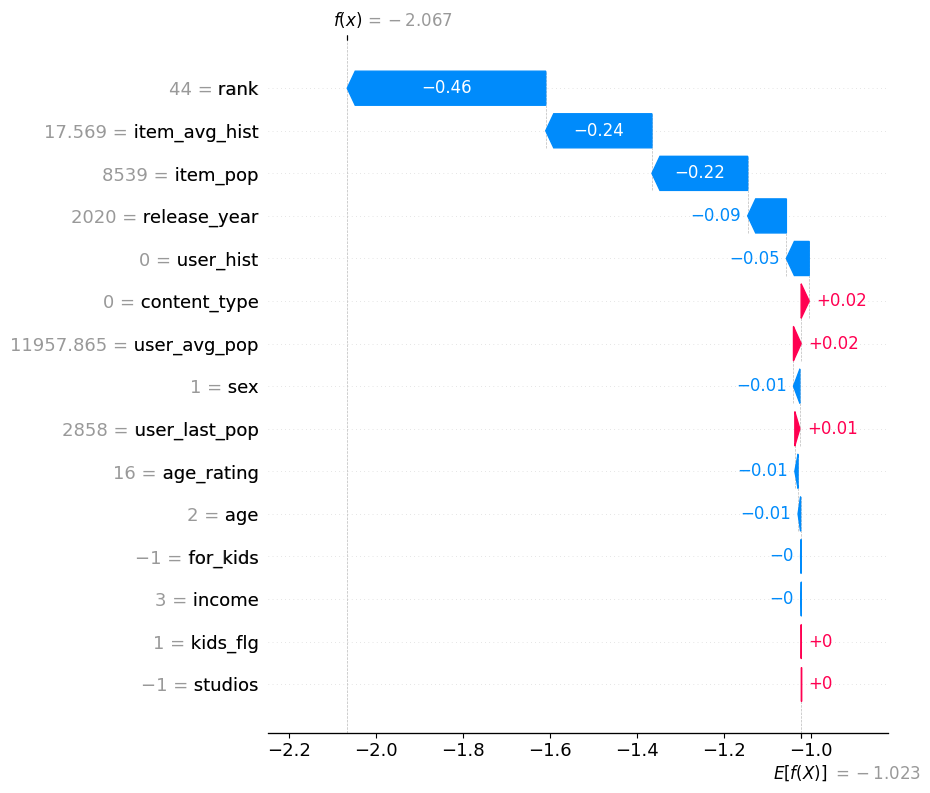

In [11]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

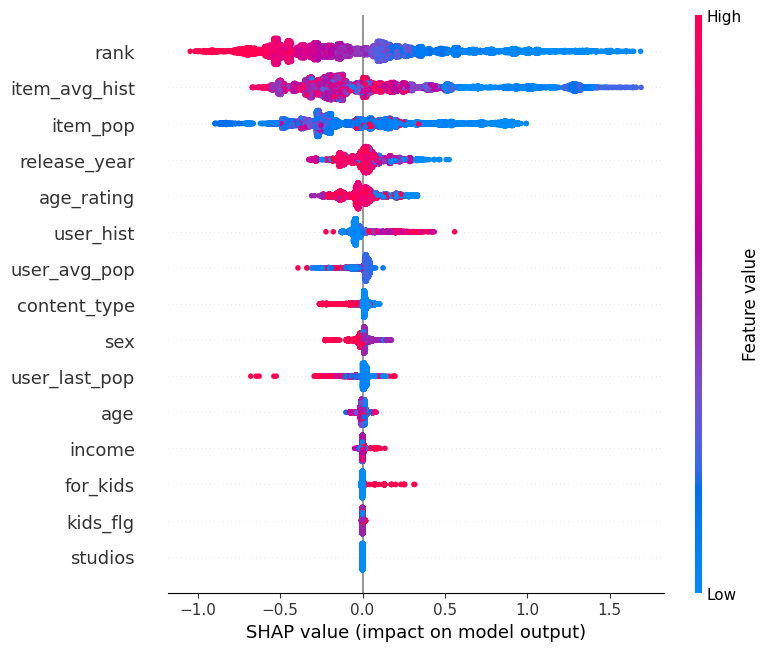

In [12]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [13]:
def add_score_and_rank(
    df: pd.DataFrame, y_pred_scores: np.ndarray, name: str
) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df["rank"] < 61).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 101
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [14]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,rank,age,income,sex,kids_flg,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
25,437491,9728,2021-07-01,0.0,0.0,3,2,3,1,1,...,-1,18.0,-1,76978.0,11.165736,0,1.660310,1,1.660310,1
45,437491,15297,2021-07-01,0.0,0.0,2,2,3,1,1,...,-1,18.0,-1,137128.0,7.364295,0,1.143096,2,1.143096,2
27,437491,10440,2021-07-01,0.0,0.0,1,2,3,1,1,...,-1,18.0,-1,141889.0,8.068716,0,1.078455,3,1.078455,3


In [15]:
y_pred_train: np.ndarray = listwise_model.predict(ranker_train[cols])
ranker_train = add_score_and_rank(ranker_train, y_pred_train, "listwise")

In [16]:
y_pred_val: np.ndarray = listwise_model.predict(ranker_val[cols])
ranker_val = add_score_and_rank(ranker_val, y_pred_val, "listwise")

In [17]:
final_predict = pd.concat([ranker_train, ranker_val, ranker_test])
final_predict.head()

,user_id,item_id,datetime,total_dur,weight,rank,age,income,sex,kids_flg,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
9,439884,15297,2021-07-01,0.0,0.0,1,2,2,0,1,...,-1,18.0,-1,137128.0,7.364295,0,2.074702,1,2.074702,1
1,439884,13865,2021-07-01,0.0,0.0,3,2,2,0,1,...,-1,12.0,-1,93403.0,10.408520,0,0.826291,2,0.826291,2
11,439884,16228,2021-07-01,0.0,0.0,29,2,2,0,1,...,0,18.0,-1,7322.0,9.994127,0,0.534265,3,0.534265,3
10,439884,16166,2021-07-01,0.0,0.0,44,2,2,0,1,...,-1,6.0,-1,8522.0,20.144802,0,-1.280527,4,-1.280527,4
3,439884,14431,2021-07-01,0.0,0.0,18,2,2,0,1,...,-1,16.0,-1,18300.0,16.277213,0,-1.431684,5,-1.431684,5


In [18]:
final_predict.to_csv("final_predict.csv", index=False, sep=";")

In [20]:
final_predict.shape

(15636711, 25)

In [22]:
# # прикопаем данные (закончился лимит на гугл диске, скачал локально)
# # без прикопа упадет по оперативной памяти
# !cp final_predict.csv /content/drive/MyDrive/itmo_recsys/lesson_6/